<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Medicine_review_ULMFiT_fastai_Short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Dependencies
Let's install PyTorch and fastai libraries first. You have to repeat this step every time you restart this notebook in colab.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

In [2]:
import torch
print(torch.__version__)
import fastai
print(fastai.__version__) #1.0.38


1.0.0
1.0.38


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

## Import Dataset

###Install Kaggle Dependencies

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!mkdir -p input
!echo '{"username":"navneetkrch","key":"4910f3543e9486158ccfa00ca84b274f"}'> ~/.kaggle/kaggle.json  # Replace
#!chmod 600 kaggle.json


In [0]:
!kaggle datasets download -d jessicali9530/kuc-hackathon-winter-2018

In [0]:
!unzip kuc-hackathon-winter-2018.zip -d input


In [0]:
train = pd.read_csv('input/drugsComTrain_raw.csv')
test = pd.read_csv('input/drugsComTest_raw.csv')

In [8]:
train.head().T

,0,1,2,3,4
uniqueID,206461,95260,92703,138000,35696
drugName,Valsartan,Guanfacine,Lybrel,Ortho Evra,Buprenorphine / naloxone
condition,Left Ventricular Dysfunction,ADHD,Birth Control,Birth Control,Opiate Dependence
review,"""It has no side effect, I take it in combinati...","""My son is halfway through his fourth week of ...","""I used to take another oral contraceptive, wh...","""This is my first time using any form of birth...","""Suboxone has completely turned my life around..."
rating,9,8,5,8,9
date,20-May-12,27-Apr-10,14-Dec-09,3-Nov-15,27-Nov-16
usefulCount,27,192,17,10,37


In [9]:
test.head().T

,0,1,2,3,4
uniqueID,163740,206473,159672,39293,97768
drugName,Mirtazapine,Mesalamine,Bactrim,Contrave,Cyclafem 1 / 35
condition,Depression,"Crohn's Disease, Maintenance",Urinary Tract Infection,Weight Loss,Birth Control
review,"""I&#039;ve tried a few antidepressants over th...","""My son has Crohn&#039;s disease and has done ...","""Quick reduction of symptoms""","""Contrave combines drugs that were used for al...","""I have been on this birth control for one cyc..."
rating,10,8,9,9,9
date,28-Feb-12,17-May-09,29-Sep-17,5-Mar-17,22-Oct-15
usefulCount,22,17,3,35,4


In [10]:
train.shape

(161297, 7)

## from_df       [source](https://github.com/fastai/fastai/blob/master/fastai/text/data.py#L157)
from_df(path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:OptDataFrame=None, tokenizer:Tokenizer=None, vocab:Vocab=None, classes:StrList=None, text_cols:Union[int, Collection[int], str, StrList]=1, label_cols:Union[int, Collection[int], str, StrList]=0, label_delim:str=None, kwargs) → DataBunch

Create a [TextDataBunch](https://docs.fast.ai/text.data.html#TextDataBunch) from DataFrames.


This method will use train_df, valid_df and maybe test_df to build the TextDataBunch in path. You can specify text_cols and label_cols.**If there are several text_cols, the texts will be concatenated together with an optional field token.**
If there are several label_cols, the labels will be assumed to be one-hot encoded and classes will default to label_cols (you can ignore that argument for a language model). tokenizer will be used to parse those texts into tokens.

You can pass a specific vocab for the numericalization step (if you are building a classifier from a language model you fine-tuned for instance). kwargs will be split between the [TextDataset](https://docs.fast.ai/text.data.html#TextDataset) function and to the class initialization, you can precise there parameters such as max_vocab, chunksize, min_freq, n_labels (see the [TextDataset](https://docs.fast.ai/text.data.html#TextDataset) documentation) or bs, bptt and pad_idx (see the sections LM data and classifier data).



##Create Dataframe
This provides the Label/Target and the associated text

In [11]:
# create a dataframe
train_df = pd.DataFrame({'label':train.rating,
                   'text':train.review})
print(train_df.shape)
train_df.head()

(161297, 2)


,label,text
0,9,"""It has no side effect, I take it in combinati..."
1,8,"""My son is halfway through his fourth week of ..."
2,5,"""I used to take another oral contraceptive, wh..."
3,8,"""This is my first time using any form of birth..."
4,9,"""Suboxone has completely turned my life around..."


In [12]:
test_df = pd.DataFrame({'label':test.rating,
                        'text':test.review})
print(test_df.shape)
test_df.head()

(53766, 2)


,label,text
0,10,"""I&#039;ve tried a few antidepressants over th..."
1,8,"""My son has Crohn&#039;s disease and has done ..."
2,9,"""Quick reduction of symptoms"""
3,9,"""Contrave combines drugs that were used for al..."
4,9,"""I have been on this birth control for one cyc..."


In [0]:
df= train_df.append(test_df, ignore_index=True)


In [14]:
df_full = train.append(test, ignore_index=True)
df_full.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [15]:
df.shape

(215063, 2)

In [16]:
df = df.reset_index(drop = True)
df.head()

,label,text
0,9,"""It has no side effect, I take it in combinati..."
1,8,"""My son is halfway through his fourth week of ..."
2,5,"""I used to take another oral contraceptive, wh..."
3,8,"""This is my first time using any form of birth..."
4,9,"""Suboxone has completely turned my life around..."


In [17]:
df['label'].value_counts()

10    68005
9     36708
1     28918
8     25046
7     12547
5     10723
2      9265
3      8718
6      8462
4      6671
Name: label, dtype: int64

## Preprocessing

Tokenization

Remove StopWords
Detokenization

In [0]:
#df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

#import nltk
#nltk.download('stopwords')

#from nltk.corpus import stopwords 
#stop_words = stopwords.words('english') 

# tokenization 
#tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
#tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
#detokenized_doc = [] 
#for i in range(len(df)): 
#    t = ' '.join(tokenized_doc[i]) 
#    detokenized_doc.append(t) 
#df['text'] = detokenized_doc

With all the preprocessing

Total time: 1:33:54

epoch	train_loss	valid_loss	accuracy

1	4.754789	4.648754	0.211260

2	4.666183	4.557329	0.219218

3	4.524086	4.437946	0.229403

4	4.361761	4.323431	0.239714

5	4.235765	4.290059	0.243043

We could achieve only 24% accuracy while when we moved to pure FASTAI processing then we achieved the accuracy of the Language Model to be starting with almost 30% and hence strengthened the beliefs in the capability of FASTAI.


In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.25, random_state = 12)

In [20]:
df_trn.shape, df_val.shape

((161297, 2), (53766, 2))

## Data Preparation

### Language model data
for learning the Language semantics

### Classifier model data
for learning the classification Task on text data

**text.learner contains helper functions to quickly create a language model or an RNN classifier**


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val,path = "")

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val,vocab=data_lm.train_ds.vocab, bs=48)

This does all the necessary preprocessing behing the scene. For the classifier, we also pass the vocabulary (mapping from ids to words) that we want to use: this is to ensure that data_clas will use the same dictionary as data_lm.



In [0]:
#Fine-tuning a language model
#We can use the data_lm object we created earlier to fine-tune a pretrained language model.
#fast.ai has an English model available that we can download. 
#We can create a learner object that will directly create a model, 
#download the pretrained weights and be ready for fine-tuning.
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)

In [24]:
# train the learner object
learn.fit_one_cycle(3, 1e-2) #18.7

epoch,train_loss,valid_loss,accuracy
1,3.914226,3.629306,0.292377
2,3.858684,3.587324,0.294758
3,3.817588,3.544761,0.298963


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save_encoder('ft_enc51')

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


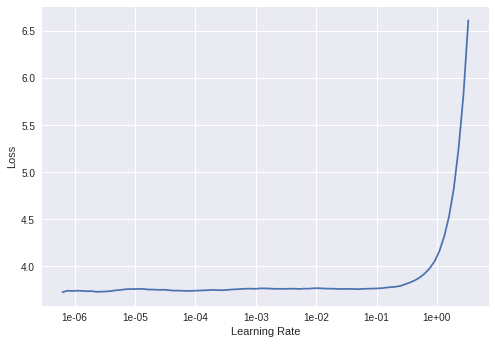

In [27]:
learn.recorder.plot()

In [28]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-2) # accuracy 36.48%

epoch,train_loss,valid_loss,accuracy
1,3.366866,3.224195,0.341396
2,3.138331,3.036599,0.364828


Total time: 1:15:38

epoch	train_loss	valid_loss	accuracy

1	3.366866	3.224195	0.341396

2	3.138331	3.036599	0.364828


In [0]:
learn.save_encoder('ft_enc52')
#this times out, so fit one cycle 5+5 instead of 10 so we store encoder as well after 5 steps

In [30]:

learn.fit_one_cycle(2, 1e-2) 
learn.save_encoder('ft_enc53')# accuracy 37.1%
#Finally we save the encoder to be able to use it for classification in the next section.

epoch,train_loss,valid_loss,accuracy
1,3.280402,3.137232,0.350499
2,3.079993,2.984949,0.371016


Total time: 1:15:29

epoch	train_loss	valid_loss	accuracy

1	3.280402	3.137232	0.350499

2	3.079993	2.984949	0.371016


In [31]:
learn.predict("This is a review about", n_words=15)

'This is a review about another- zeldox sandexa coffee swap intra aderall ultimate associated foward lipofen arbs klonipin aggressive maniac'

##Building a classifier
We now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder. The learner object can be done in a single line.



epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


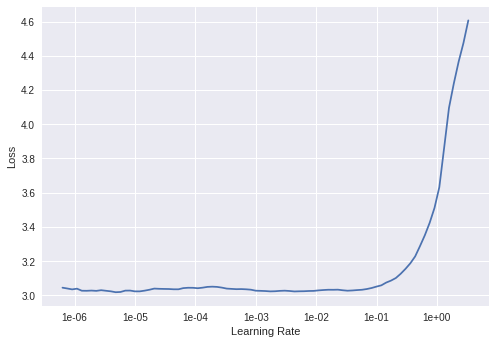

In [33]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#load the encoder models in models folder
#!mkdir models
#!mv ft_enc53.pth models/
#!mv tmp.pth models/

In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.7)
learn.load_encoder('ft_enc53')

In [35]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.698130,1.558233,0.439534


In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))


epoch,train_loss,valid_loss,accuracy
1,1.501788,1.414917,0.478574


In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))


epoch,train_loss,valid_loss,accuracy


In [0]:
print("process completed")